# PROBLEM STATEMENT

On 14 March 2019, tropical Cyclone Idai made landfall at the port of Beira, Mozambique, before moving across the region. Millions of people in Malawi, Mozambique and Zimbabwe have been affected by what is the worst natural disaster to hit southern Africa in at least two decades.

In recent decades, countries across Africa have experienced an increase in the frequency and severity of floods. Malawi has been hit with major floods in 2015 and again in 2019. In fact, between 1946 and 2013, floods accounted for 48% of major disasters in Malawi. The Lower Shire Valley in southern Malawi, bordering Mozambique, composed of Chikwawa and Nsanje Districts is the area most prone to flooding.

NOTE: For this competition, the training data is the flood extent in 2015 in southern Malawi, however, you are encouraged to source other flood data for other nearby regions and other historic floods to train your model

The test data to measure the accuracy of your model is the flood extent in southern Malawi in 2019

The objective of this challenge is to build a machine learning model that helps predict the location and extent of floods in southern Malawi.

# HYPOTHESIS GENERATION

Southern Malawi experienced major flooding in '2015' and again in '2019' with cyclone Idai. Approximate dates of impact are 13 January 2015 and 14 March 2019, respectively. Cool it will be best to work with these month frame; January to March data 2015 and 2019 respectively and since target is the percentage of the given rectangle that was flooded, with a value between 0 and 1; this could be address as a classification problem (an hypothesis: might be true or not) So what are the possible hypothesis that could influence or affect a given region been flooded over a period of time
- Rainfall is variable, erratic and rainfall in the 'highlands' often causes floods in the low-lying areas. 
- Extensive deforestation increases runoff and the overall flood risk.
- The combined effects of floods and droughts in malawi causes losses of at least 1.7% of Malawi’s GDP annually
- Recent research shows that smallholder farmers lose 2.67% of their agricultural produce to flooding each year
- High levels of poverty, a lack of access to land and a growing population means people have smaller pieces of land for farming. This has led to settlements in marginalised areas that are prone to flooding
NB: the impact of disasters like floods is a consequence of social and economic factors, For instance, high poverty levels mean people lack access to land and work and they are often driven to settle in zones that are more exposed to natural hazards.

In summary, based on our hypothesis which could be true or not; the following was generated;
1. Rainfall
2. Extensive deforestation
3. Annual Malawi’s GDP
4. poverty rate
5. Population
6. Areas
7. Slope (Topography)

# IMPORT DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import KFold, cross_val_score, GroupKFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
import gc
import warnings
warnings.filterwarnings('ignore')

C:\Users\DELL\Anaconda3\lib\site-packages\distributed\utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10051] A socket operation was attempted to an unreachable network
  RuntimeWarning,


In [2]:
samp = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\SampleSubmission.csv')
df = pd.read_csv(r'C:\Users\DELL\Desktop\Hackhathons\flood\Train.csv')

In [3]:
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency
precip_features_2019 = []
precip_features_2015 = []
for col in df.columns:
  if '2019' in col:
    precip_features_2019.append(col)
  elif 'precip 2014' in col:
    precip_features_2015.append(col)
  elif 'precip 2015' in col:
    precip_features_2015.append(col)

In [4]:
 #Separating the train dataset from the main dataframe
train = df[df.columns.difference(precip_features_2019)]
train.head(2)

,LC_Type1_mode,Square_ID,X,Y,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,...,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,target_2015
0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,0.0,0.0,0.0,14.844025,14.552823,...,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0
1,9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,0.0,0.0,0.0,14.844025,14.552823,...,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,0.0


In [5]:
train.columns

Index(['LC_Type1_mode', 'Square_ID', 'X', 'Y', 'elevation',
       'precip 2014-11-16 - 2014-11-23', 'precip 2014-11-23 - 2014-11-30',
       'precip 2014-11-30 - 2014-12-07', 'precip 2014-12-07 - 2014-12-14',
       'precip 2014-12-14 - 2014-12-21', 'precip 2014-12-21 - 2014-12-28',
       'precip 2014-12-28 - 2015-01-04', 'precip 2015-01-04 - 2015-01-11',
       'precip 2015-01-11 - 2015-01-18', 'precip 2015-01-18 - 2015-01-25',
       'precip 2015-01-25 - 2015-02-01', 'precip 2015-02-01 - 2015-02-08',
       'precip 2015-02-08 - 2015-02-15', 'precip 2015-02-15 - 2015-02-22',
       'precip 2015-02-22 - 2015-03-01', 'precip 2015-03-01 - 2015-03-08',
       'precip 2015-03-08 - 2015-03-15', 'target_2015'],
      dtype='object')

#### TRAIN DATA - MINIMUM AND MAXIMUN PRECIPITATION FOR EACH MONTH

In [6]:
#November 2014
print(train['precip 2014-11-16 - 2014-11-23'].max(), train[ 'precip 2014-11-23 - 2014-11-30'].max())
print(train['precip 2014-11-16 - 2014-11-23'].min(), train[ 'precip 2014-11-23 - 2014-11-30'].min())

19.3549693227 41.0238580704
0.0 0.0


In [7]:
#December 2014                
print(train['precip 2014-11-30 - 2014-12-07'].max(), train[ 'precip 2014-12-07 - 2014-12-14'].max(),
      train['precip 2014-12-14 - 2014-12-21'].max(), train['precip 2014-12-21 - 2014-12-28'].max())
print(train['precip 2014-11-30 - 2014-12-07'].min(), train[ 'precip 2014-12-07 - 2014-12-14'].min(),
      train['precip 2014-12-14 - 2014-12-21'].min(), train['precip 2014-12-21 - 2014-12-28'].min())

22.0208032429 18.8706746399 23.0443397015 21.7578277439
0.0 1.4114522934 3.5803415477 1.2540975511


In [8]:
#January 2015 
print(train['precip 2014-12-28 - 2015-01-04'].max(), train['precip 2015-01-04 - 2015-01-11'].max(),
     train['precip 2015-01-11 - 2015-01-18'].max(),  train['precip 2015-01-18 - 2015-01-25'].max(),train['precip 2015-01-25 - 2015-02-01'].max())
print(train['precip 2014-12-28 - 2015-01-04'].min(), train[ 'precip 2015-01-04 - 2015-01-11'].min(),
       train['precip 2015-01-11 - 2015-01-18'].min(),  train['precip 2015-01-18 - 2015-01-25'].min(),train['precip 2015-01-25 - 2015-02-01'].min())

62.4334321842 51.19742038850001 105.275891304 11.1036581993 53.014242857700005
7.4629985392 15.6481544971 30.449467808 0.0 14.964382588900001


In [9]:
#February 2015              #new featuees- if 0 no prep recorded  #new features-precp record for each year in malawi
print(train['precip 2015-02-01 - 2015-02-08'].max(), train['precip 2015-02-08 - 2015-02-15'].max(),
      train['precip 2015-02-15 - 2015-02-22'].max(), train['precip 2015-02-22 - 2015-03-01'].max())
print(train['precip 2015-02-01 - 2015-02-08'].min(), train[ 'precip 2015-02-08 - 2015-02-15'].min(),
      train['precip 2015-02-15 - 2015-02-22'].min(), train['precip 2015-02-22 - 2015-03-01'].min())

44.34131233390001 28.5599232763 15.7150078416 36.9649925008
13.261280149200001 0.45906710619999996 0.27900150420000003 6.7286853194


In [10]:
#March 2015     
print(train['precip 2015-03-01 - 2015-03-08'].max(), train['precip 2015-03-08 - 2015-03-15'].max())
print(train['precip 2015-03-01 - 2015-03-08'].min(), train['precip 2015-03-08 - 2015-03-15'].min())

25.7116487622 4.9533213973
3.2834250331 0.0


In [11]:
# Separating the test dataset from the main dataframe
precip_features_2019.extend(['X','Y','elevation', 'LC_Type1_mode','Square_ID'])
test = df[precip_features_2019]
test.head(2)

,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,...,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,X,Y,elevation,LC_Type1_mode,Square_ID
0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,0.0,0.0,34.26,-15.91,887.764222,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,...,0.0,0.0,0.0,0.0,0.0,34.26,-15.90,743.403912,9,4e3c3897-14ce-11ea-bce5-f49634744a41


In [12]:
print(train['elevation'].min() ,train['elevation'].max())
print(test['elevation'].min() ,test['elevation'].max())

45.541443808000004 2803.3036448776
45.541443808000004 2803.3036448776


In [13]:
train['target_2015'].unique()

array([0.        , 0.06973359, 0.15617288, ..., 0.96692349, 0.62270307,
       0.0572244 ])

# BIVARIATE ANALYSIS

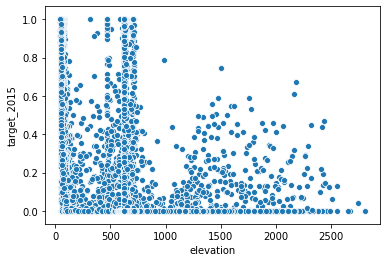

In [14]:
sns.scatterplot(x ='elevation', y ='target_2015', data =train)

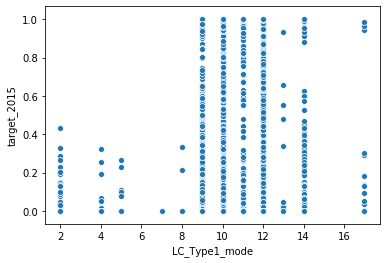

In [15]:
sns.scatterplot(x ='LC_Type1_mode', y ='target_2015', data =train)

In [16]:
train['LC_Type1_mode'].unique()

array([ 9, 10,  8,  4, 12,  5, 13, 14,  2, 11, 17,  7], dtype=int64)

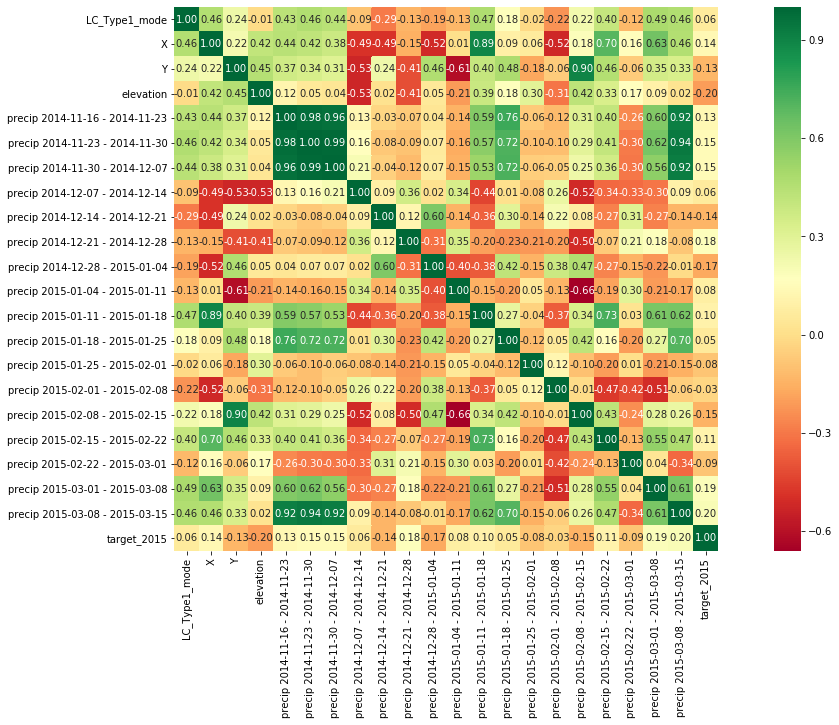

In [17]:
#correlelogram- plot heatmap to find correlation among features
corrmat =train.corr()
f, ax = plt.subplots(figsize=(20,10))
#sns.heatmap(corrmat, square=True, annot=True,linewidth=0.8, cmap='RdBu')
# data.corr()
#plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), square=True, cmap=plt.cm.RdYlGn, annot=True, fmt=".2f")
#wk1, wk2, wk3 -same multicollinearity

In [18]:
test.columns

Index(['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19', 'X', 'Y', 'elevation',
       'LC_Type1_mode', 'Square_ID'],
      dtype='object')

#### TEST DATA - MINIMUM AND MAXIMUN PRECIPITATION FOR EACH MONTH

In [19]:
#january 2019
print(test['precip 2019-01-20 - 2019-01-27'].max(), test['precip 2019-01-27 - 2019-02-03'].max())
print(test['precip 2019-01-20 - 2019-01-27'].min(), test['precip 2019-01-27 - 2019-02-03'].min())

25.101563021500002 22.7741479874
3.8138642311 0.0


In [20]:
#february 2019
print(test['precip 2019-02-03 - 2019-02-10'].max(), test['precip 2019-02-10 - 2019-02-17'].max(), test['precip 2019-02-17 - 2019-02-24'].max()
     ,test['precip 2019-02-24 - 2019-03-03'].max())
print(test['precip 2019-02-03 - 2019-02-10'].min(), test['precip 2019-02-10 - 2019-02-17'].min(), test['precip 2019-02-17 - 2019-02-24'].min()
       ,test['precip 2019-02-24 - 2019-03-03'].min())

46.2255039215 21.9481572211 52.682311713699995 21.275595128499997
12.4503189325 2.8015456796 12.780855476900001 0.0


In [21]:
#march 2019
print(test['precip 2019-03-03 - 2019-03-10'].max(), test['precip 2019-03-10 - 2019-03-17'].max(), test['precip 2019-03-17 - 2019-03-24'].max()
     ,test['precip 2019-03-24 - 2019-03-31'].max())
print(test['precip 2019-03-03 - 2019-03-10'].min(), test['precip 2019-02-10 - 2019-02-17'].min(), test['precip 2019-03-17 - 2019-03-24'].min()
       ,test['precip 2019-03-24 - 2019-03-31'].min())

84.675319016 36.7408089638 72.1231850386 16.4036380053
32.1082264781 2.8015456796 15.803428769100002 0.0


In [22]:
#April 2019
print(test['precip 2019-03-31 - 2019-04-07'].max(),test['precip 2019-04-07 - 2019-04-14'].max(), test['precip 2019-04-14 - 2019-04-21'].max()
     ,test['precip 2019-04-21 - 2019-04-28'].max())
print(test['precip 2019-03-31 - 2019-04-07'].min(), test['precip 2019-04-07 - 2019-04-14'].min(), test['precip 2019-04-14 - 2019-04-21'].min()
       ,test['precip 2019-04-21 - 2019-04-28'].min())

37.0599796176 12.979453921300001 46.3678489923 19.4758464098
0.0 0.0 0.0 0.0


In [23]:
#May 2019
print(test['precip 2019-04-28 - 2019-05-05'].max(),test['precip 2019-05-05 - 2019-05-12'].max(),test['precip 2019-05-12 - 2019-05-19'].max())
print(test['precip 2019-04-28 - 2019-05-05'].min(),test['precip 2019-05-05 - 2019-05-12'].min(), test['precip 2019-05-12 - 2019-05-19'].min())

6.9148337245 18.1700505614 20.092776596500002
0.0 0.0 0.0


In [24]:
# Creating a dictionary of column names to be renamed for the training dataset
# The column names are renamed for conveniency
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'

    
# Creating a dictionary of column names to be renamed for the testing dataset
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
# Renaming the columns
train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)

# DETECTING OUTLIERS

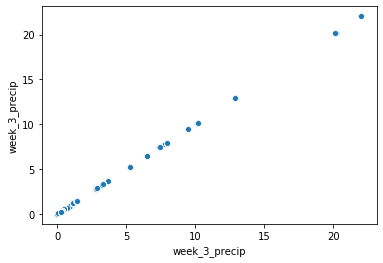

In [25]:
sns.scatterplot(x='week_3_precip', y='week_3_precip', data=train)

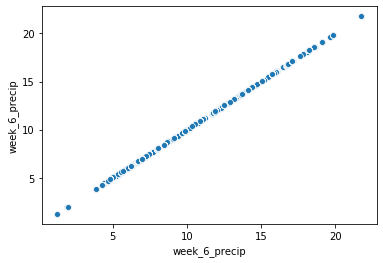

In [26]:
sns.scatterplot(x='week_6_precip', y='week_6_precip', data=train)

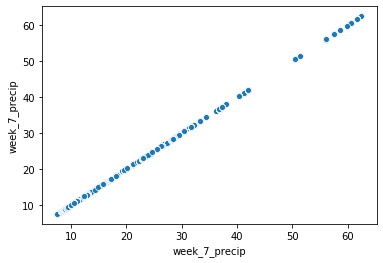

In [27]:
sns.scatterplot(x='week_7_precip', y='week_7_precip', data=train)

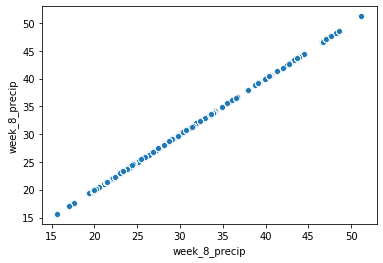

In [28]:
sns.scatterplot(x='week_8_precip', y='week_8_precip', data=train)

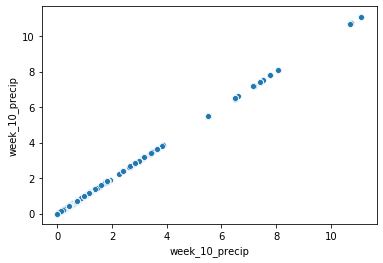

In [29]:
sns.scatterplot(x='week_10_precip', y='week_10_precip', data=train)

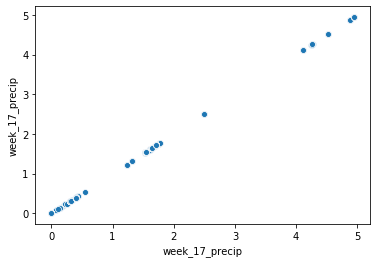

In [30]:
sns.scatterplot(x='week_17_precip', y='week_17_precip', data=train)

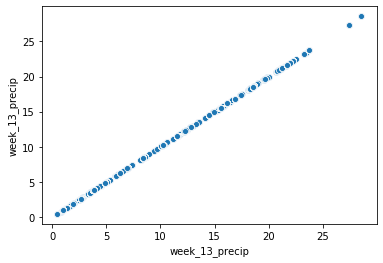

In [31]:
sns.scatterplot(x='week_13_precip', y='week_13_precip', data=train)

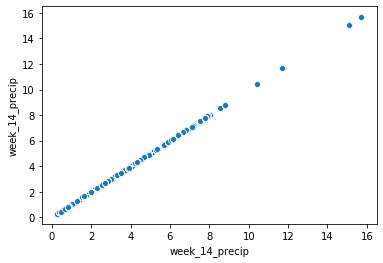

In [32]:
sns.scatterplot(x='week_14_precip', y='week_14_precip', data=train)

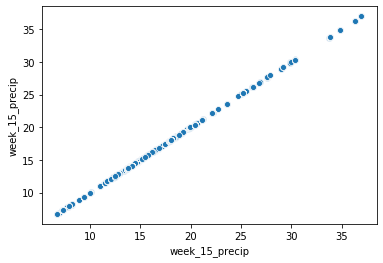

In [33]:
sns.scatterplot(x='week_15_precip', y='week_15_precip', data=train)

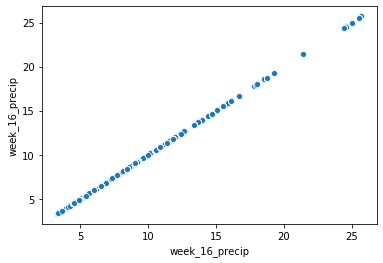

In [34]:
sns.scatterplot(x='week_16_precip', y='week_16_precip', data=train)

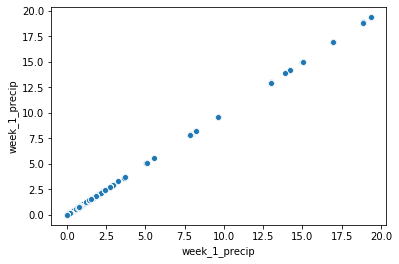

In [35]:
#new plot
sns.scatterplot(x='week_1_precip', y='week_1_precip', data=train)

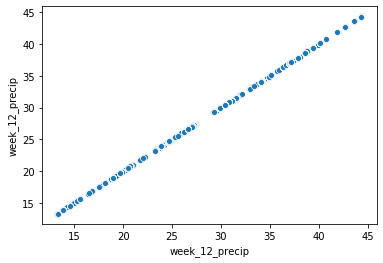

In [36]:
sns.scatterplot(x='week_12_precip', y='week_12_precip', data=train) #wk2-35, wk315

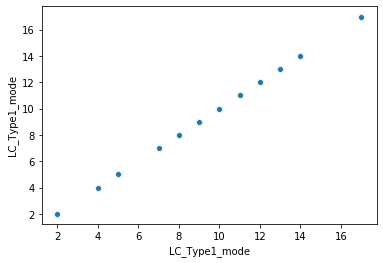

In [37]:
sns.scatterplot(x='LC_Type1_mode', y='LC_Type1_mode', data=train)

# BIVARIATE ANALYSIS - 2

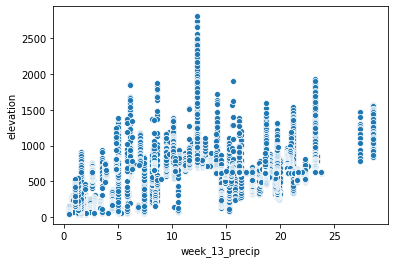

In [38]:
sns.scatterplot(x='week_13_precip', y='elevation', data=train)

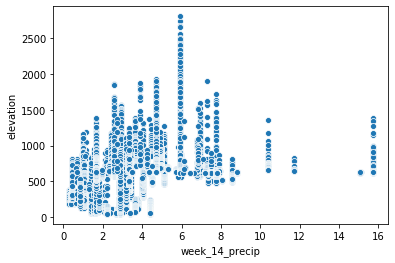

In [39]:
sns.scatterplot(x='week_14_precip', y='elevation', data=train)

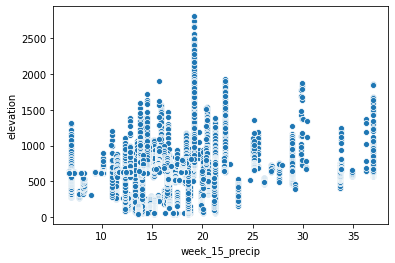

In [40]:
sns.scatterplot(x='week_15_precip', y='elevation', data=train)

In [41]:
wk6 = train[train['week_6_precip'] > 21].index
wk13 = train[train['week_13_precip'] > 25].index
wk14 = train[train['week_14_precip'] > 14].index
wk15 = train[train['week_15_precip'] > 32].index
wk16 = train[train['week_16_precip'] > 20].index
wk10 = train[train['week_10_precip'] > 9].index

In [42]:
# Drop those rows from the training data; Outliers data
train.drop(wk6, axis=0, inplace=True)
train.drop(wk13, axis=0, inplace=True)
train.drop(wk14, axis=0, inplace=True)
train.drop(wk15, axis=0, inplace=True)
train.drop(wk10, axis=0, inplace=True)

In [43]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

['LC_Type1_mode',
 'Square_ID',
 'X',
 'Y',
 'elevation',
 'week_1_precip',
 'week_2_precip',
 'week_3_precip',
 'week_4_precip',
 'week_5_precip',
 'week_6_precip',
 'week_7_precip',
 'week_8_precip',
 'week_9_precip',
 'week_10_precip',
 'week_11_precip',
 'week_12_precip',
 'week_13_precip',
 'week_14_precip',
 'week_15_precip',
 'week_16_precip',
 'week_17_precip',
 'target_2015']

In [44]:
features=[ 'week_1_precip','week_2_precip','week_3_precip', 'week_4_precip', 'week_5_precip',
          'week_6_precip', 'week_7_precip', 'week_8_precip', 'week_9_precip',
          'week_10_precip', 'week_11_precip', 'week_12_precip', 'week_13_precip',
          'week_14_precip', 'week_15_precip', 'week_16_precip', 'week_17_precip'
         ]

In [45]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x  

In [46]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:50<00:00,  2.99s/it]


In [47]:
train=data[data.target_2015.notnull()].reset_index(drop=True)
test=data[data.target_2015.isna()].reset_index(drop=True)

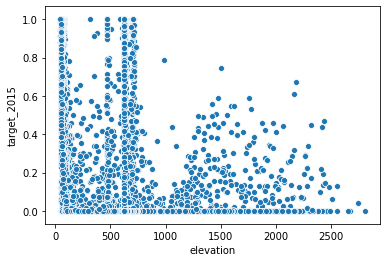

In [48]:
sns.scatterplot(x='elevation', y='target_2015', data=train)

In [49]:
test_id = test['Square_ID']

In [50]:
train = train.drop(['Square_ID'], axis=1)

In [51]:
test = test.drop(['Square_ID'], axis=1)

In [52]:
test = test.drop('target_2015', axis=1)

In [53]:
print(train.shape, test.shape)

(15343, 73) (16466, 72)


In [54]:
X = train.drop(['target_2015'], axis=1)
y = train['target_2015']

In [55]:
test.shape

(16466, 72)

In [56]:
X_fold, X_val, y_fold, y_val = train_test_split(X, y, test_size=0.25, random_state=12345)

In [57]:
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse','sub_sample':0.9,
    'max_depth': 12 ,
    'learning_rate': 0.054320,
    'feature_fraction': 0.9,'seed':1899,
    'verbose': 0}

In [58]:
errcb=[]
y_pred_totcb=[]
fold=RepeatedKFold(n_splits=4, random_state=1992, n_repeats=4)
i=1

for train_index, test_index in fold.split(X_fold, y_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMRegressor(**param, random_state=188)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=50, early_stopping_rounds=100)
    preds=m.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb.append(np.sqrt(mean_squared_error(y_test,preds)))
    p = m.predict(test)
    y_pred_totcb.append(p)

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.0807041	valid_1's rmse: 0.0854752
[100]	training's rmse: 0.0719962	valid_1's rmse: 0.0807105
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0719962	valid_1's rmse: 0.0807105
err:  0.08071052316928637
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.0787629	valid_1's rmse: 0.0953563
[100]	training's rmse: 0.0701904	valid_1's rmse: 0.0898025
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0701904	valid_1's rmse: 0.0898025
err:  0.08980249437493701
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.0792669	valid_1's rmse: 0.0896161
[100]	training's rmse: 0.0702641	valid_1's rmse: 0.0860962
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.0702641	valid_1's rmse: 0.0860962
err:  0.08609617986272072
Training until validation scores don't improve for 100 rounds
[5

In [59]:
np.mean(errcb)

0.08440433871492324

# FEATURE IMPORTANCE

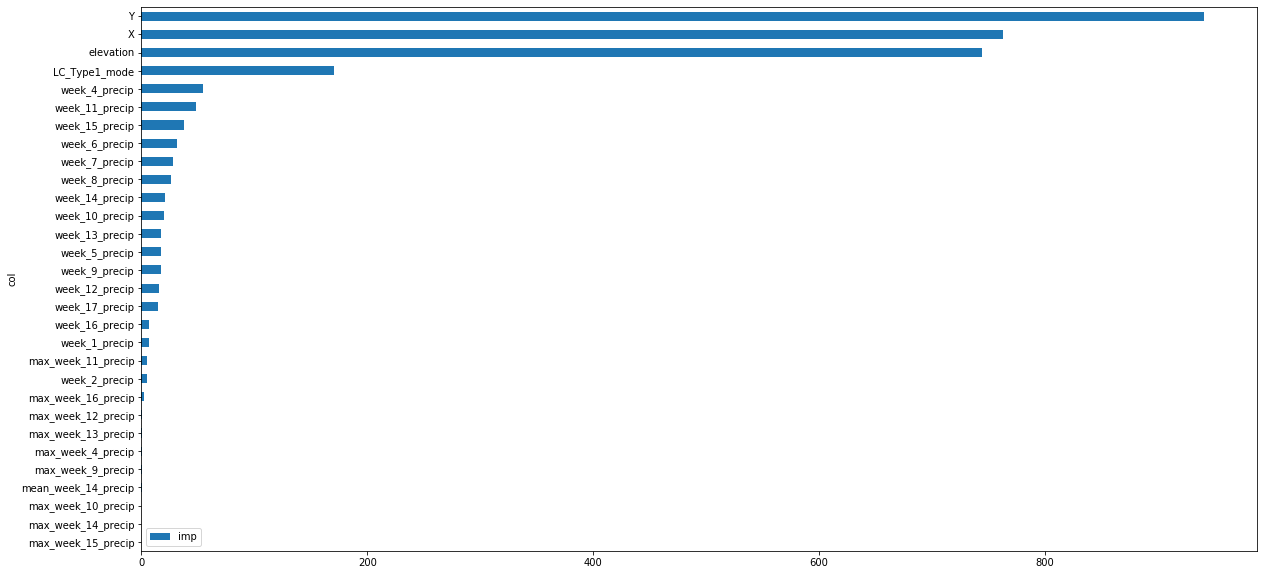

In [60]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [61]:
d = {"Square_ID": samp['Square_ID'], 'target_2015':np.mean(y_pred_totcb,0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Square_ID", 'target_2015']]

In [62]:
test_predictions.head()

,Square_ID,target_2015
0,4e3c3896-14ce-11ea-bce5-f49634744a41,-0.000103
1,4e3c3897-14ce-11ea-bce5-f49634744a41,-0.000103
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.011284
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.021221
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.021255


In [63]:
test_predictions.to_csv('MODELC-0.07677.csv', index=False)

# PLOT PREDICTION

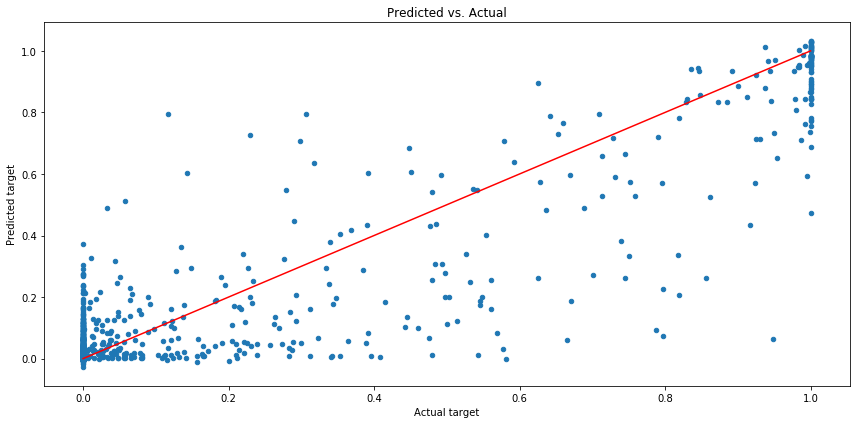

In [64]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, preds, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual target')
plt.ylabel('Predicted target')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],'r')
plt.tight_layout()